# SCC5977 - Aprendizado de Máquina para Séries Temporais (2024)

## Grupo
> André Guarnier De Mitri - 11395579 \
> Fabio Cavaleti - 11200550\
> Giovani Decico Lucafó - 10288779

## Problema
- A Kolmogorov Arnold Network consegue resolver problemas de classificação em Séries Temporais?
- Se ela for utilizada com um extrator de feature o seu resultado melhora?


# KAN

Aqui treinamos a rede KAN, com parametros
> steps = 20 \
> width=[[137, 0], [50, 0], [30, 0], [3, 0]] \
> grid=5 \
> seed=42

A série é univariada de tamanho 137 e possuí 3 classes.

In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from aeon.datasets import load_from_ts_file
from sklearn.preprocessing import LabelEncoder
from kan import KAN
import torch

# Settings
NUM_EXPERIMENTS = 5
steps = 50

# Load training and testing datasets
if not os.path.exists("./data/ts_files/train.ts") or not os.path.exists("./data/ts_files/test.ts"):
    raise FileNotFoundError("Train or test .ts files not found in the specified directory.")

X_train, y_train = load_from_ts_file("./data/ts_files/train.ts")
X_test, y_test = load_from_ts_file("./data/ts_files/test.ts")

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data for KAN
train_input = torch.from_numpy(X_train.squeeze(1)).float().to(device)
train_label = torch.from_numpy(y_train_encoded).long().to(device)
test_input = torch.from_numpy(X_test.squeeze(1)).float().to(device)
test_label = torch.from_numpy(y_test_encoded).long().to(device)

# Extract dimensions for KAN
n_instances, n_timepoints = train_input.shape  # 6000, 137
n_classes = len(np.unique(y_train_encoded))  # number of unique classes

# Prepare dataset for KAN
dataset = {
    "train_input": train_input,
    "train_label": train_label,
    "test_input": test_input,
    "test_label": test_label,
}

# Iteratively refine grids
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
experiment_num = []

def train_acc():
    return torch.mean((torch.argmax(kan_model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(kan_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

for experiment in range(NUM_EXPERIMENTS):
    kan_model = KAN(
        ckpt_path='./kan_results',
        width=[[n_timepoints, 0], [50, 0], [30, 0], [n_classes, 0]],
        grid=5,
        k=3,
        seed=42,
        device=device,
    )

    # Train the model and capture the results
    results = kan_model.fit(
        dataset=dataset,
        steps=steps,
        metrics=(train_acc, test_acc),
        loss_fn=torch.nn.CrossEntropyLoss(),
        log=1,
    )
    experiment_num.append(experiment)
    train_losses.append(results["train_loss"][-1])
    test_losses.append(results["test_loss"][-1])
    train_accuracies.append(results["train_acc"][-1])
    test_accuracies.append(results["test_acc"][-1])

# Save the metrics to JSON
metrics = {
    "experiment": experiment_num,
    "train_loss": [loss.item() for loss in train_losses],
    "test_loss": [loss.item() for loss in test_losses],
    "train_acc": train_accuracies,
    "test_acc": test_accuracies,
}
with open("kan_metrics.json", "w") as f:
    json.dump(metrics, f)

checkpoint directory created: ./kan_results
saving model version 0.0


| train_loss: 8.32e-03 | test_loss: 2.84e+00 | reg: 9.99e+02 | : 100%|█| 50/50 [01:25<00:00,  1.71s/


saving model version 0.1
checkpoint directory created: ./kan_results
saving model version 0.0


| train_loss: 4.08e-04 | test_loss: 3.82e+00 | reg: 2.03e+03 | : 100%|█| 50/50 [01:19<00:00,  1.59s/


saving model version 0.1
checkpoint directory created: ./kan_results
saving model version 0.0


| train_loss: 4.08e-04 | test_loss: 3.82e+00 | reg: 2.03e+03 | : 100%|█| 50/50 [01:17<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./kan_results
saving model version 0.0


| train_loss: 4.08e-04 | test_loss: 3.82e+00 | reg: 2.03e+03 | : 100%|█| 50/50 [01:17<00:00,  1.55s/


saving model version 0.1
checkpoint directory created: ./kan_results
saving model version 0.0


| train_loss: 4.08e-04 | test_loss: 3.82e+00 | reg: 2.03e+03 | : 100%|█| 50/50 [01:18<00:00,  1.57s/


saving model version 0.1


# Treinamento da FCN
Aqui uma FCN é treinada com parâmetros
> max_epochs = 100
> dimension_num = 1 (series univariadas)
> num_classes = 3

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.fcn import FCNClassifier
from utils import TimeSeriesClassifier, TimeSeriesDataset
from kan import KAN
from aeon.datasets import load_from_ts_file
import pandas as pd
from pytorch_lightning.loggers.wandb import WandbLogger

# SETTINGS
NUM_EXPERIMENTS = 5
activation_fn = nn.ReLU()
max_epochs=100

# Load time series data
X_train, y_train = load_from_ts_file("./data/ts_files/train.ts")
X_test, y_test = load_from_ts_file("./data/ts_files/test.ts")

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Infer sequence length and dimensions
sequence_len = X_train.shape[-1]
dimension_num = X_train.shape[1] if len(X_train.shape) > 1 else 1

# Datasets
train_dataset = TimeSeriesDataset(X_train, y_train_encoded)
test_dataset = TimeSeriesDataset(X_test, y_test_encoded)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Results
results_dict = {
    'experiment': [],
    'accuracy': [],
    'f1': []
}
for experiment in range(NUM_EXPERIMENTS):

    # Model and optimizer
    fcn_model = FCNClassifier(
        dimension_num=dimension_num,
        activation=activation_fn,
        num_classes=num_classes
    )
    optimizer = torch.optim.Adadelta(fcn_model.parameters(), lr=1e-3, eps=1e-8)
    model_classifier = TimeSeriesClassifier(model=fcn_model, optimizer=optimizer)
    wandb_logger = WandbLogger(log_model="all", project="FCN")

    # Define checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        dirpath="experiments",
        filename=f"fcn_kan_{experiment}",
        save_top_k=1,
        monitor="f1",
        mode="max"
    )

    # Trainer setup
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        devices=-1,
        callbacks=[checkpoint_callback],
        logger=wandb_logger, 
        enable_model_summary = False
    )

    # Train the FCNClassifier model
    trainer.fit(model_classifier, train_loader)
    results = trainer.test(model_classifier, test_loader)
    results_dict['experiment'].append(experiment)
    results_dict['accuracy'].append(results[0]['accuracy'])
    results_dict['f1'].append(results[0]['f1'])

    results_dataframe = pd.DataFrame(results_dict)
    results_dataframe.to_csv(f'./results_fcn_{experiment}.csv', index=False)

    #  Finish logging
    wandb_logger.log_metrics({"experiment": experiment})
    wandb_logger.finalize("success")

    # Free GPU
    # device = torch.device("cpu")
    # model_classifier.to(device)
    # model = None
    # model_classifier = None
    # torch.cuda.empty_cache()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: andremitri. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0:   0%|          | 0/94 [00:00<?, ?it/s] 

c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(


Epoch 1:   0%|          | 0/94 [00:00<?, ?it/s, v_num=2ora, train_loss_step=1.010, train_accuracy_step=0.500, train_f1_step=0.384, train_loss_epoch=1.040, train_accuracy_epoch=0.483, train_f1_epoch=0.380]         

c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:384: `ModelCheckpoint(monitor='f1')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_accuracy', 'train_accuracy_step', 'train_f1', 'train_f1_step', 'train_loss_epoch', 'train_accuracy_epoch', 'train_f1_epoch', 'epoch', 'step']. HINT: Did you call `log('f1', value)` in the `LightningModule`?


Epoch 99: 100%|██████████| 94/94 [00:23<00:00,  3.96it/s, v_num=2ora, train_loss_step=0.669, train_accuracy_step=0.771, train_f1_step=0.768, train_loss_epoch=0.733, train_accuracy_epoch=0.724, train_f1_epoch=0.722]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 94/94 [00:23<00:00,  3.96it/s, v_num=2ora, train_loss_step=0.669, train_accuracy_step=0.771, train_f1_step=0.768, train_loss_epoch=0.733, train_accuracy_epoch=0.724, train_f1_epoch=0.722]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 114.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.40666666626930237    │
│            f1             │    0.20691214501857758    │
│           loss            │     1.069551706314087     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 99: 100%|██████████| 94/94 [00:22<00:00,  4.09it/s, v_num=2ora, train_loss_step=0.710, train_accuracy_step=0.688, train_f1_step=0.684, train_loss_epoch=0.733, train_accuracy_epoch=0.723, train_f1_epoch=0.723]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 94/94 [00:22<00:00,  4.09it/s, v_num=2ora, train_loss_step=0.710, train_accuracy_step=0.688, train_f1_step=0.684, train_loss_epoch=0.733, train_accuracy_epoch=0.723, train_f1_epoch=0.723]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 138.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.3686666786670685     │
│            f1             │    0.20630161464214325    │
│           loss            │    1.1063520908355713     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 99: 100%|██████████| 94/94 [00:22<00:00,  4.10it/s, v_num=2ora, train_loss_step=0.731, train_accuracy_step=0.750, train_f1_step=0.745, train_loss_epoch=0.742, train_accuracy_epoch=0.712, train_f1_epoch=0.713]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 94/94 [00:22<00:00,  4.10it/s, v_num=2ora, train_loss_step=0.731, train_accuracy_step=0.750, train_f1_step=0.745, train_loss_epoch=0.742, train_accuracy_epoch=0.712, train_f1_epoch=0.713]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 136.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.38866665959358215    │
│            f1             │    0.20897795259952545    │
│           loss            │     1.100414752960205     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 99: 100%|██████████| 94/94 [00:23<00:00,  4.00it/s, v_num=2ora, train_loss_step=0.814, train_accuracy_step=0.583, train_f1_step=0.561, train_loss_epoch=0.733, train_accuracy_epoch=0.720, train_f1_epoch=0.718]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 94/94 [00:23<00:00,  4.00it/s, v_num=2ora, train_loss_step=0.814, train_accuracy_step=0.583, train_f1_step=0.561, train_loss_epoch=0.733, train_accuracy_epoch=0.720, train_f1_epoch=0.718]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 107.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.3946666717529297     │
│            f1             │    0.21130304038524628    │
│           loss            │    1.0900062322616577     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 99: 100%|██████████| 94/94 [00:24<00:00,  3.77it/s, v_num=2ora, train_loss_step=0.766, train_accuracy_step=0.771, train_f1_step=0.758, train_loss_epoch=0.734, train_accuracy_epoch=0.724, train_f1_epoch=0.721]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 94/94 [00:24<00:00,  3.77it/s, v_num=2ora, train_loss_step=0.766, train_accuracy_step=0.771, train_f1_step=0.758, train_loss_epoch=0.734, train_accuracy_epoch=0.724, train_f1_epoch=0.721]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 120.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.39266666769981384    │
│            f1             │    0.20188860595226288    │
│           loss            │     1.077689528465271     │
└───────────────────────────┴───────────────────────────┘

## Treinamento da FCN + KAN
Aqui a FCN + KAN é treinada a partir do embedding extraido da GAP layer da FCN após pegarmos o melhor modelo FCN

checkpoint directory created: ./kan_fcn
saving model version 0.0


| train_loss: 2.88e-01 | test_loss: 1.33e+00 | reg: 7.72e+02 | : 100%|█| 50/50 [01:11<00:00,  1.42s/


saving model version 0.1
checkpoint directory created: ./kan_fcn
saving model version 0.0


| train_loss: 2.84e-01 | test_loss: 1.59e+00 | reg: 8.60e+02 | : 100%|█| 50/50 [01:13<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./kan_fcn
saving model version 0.0


| train_loss: 3.13e-01 | test_loss: 1.52e+00 | reg: 7.56e+02 | : 100%|█| 50/50 [01:13<00:00,  1.46s/


saving model version 0.1
checkpoint directory created: ./kan_fcn
saving model version 0.0


| train_loss: 2.44e-01 | test_loss: 1.49e+00 | reg: 8.14e+02 | : 100%|█| 50/50 [01:09<00:00,  1.38s/


saving model version 0.1
checkpoint directory created: ./kan_fcn
saving model version 0.0


| train_loss: 2.84e-01 | test_loss: 1.59e+00 | reg: 8.60e+02 | : 100%|█| 50/50 [01:12<00:00,  1.45s/


saving model version 0.1


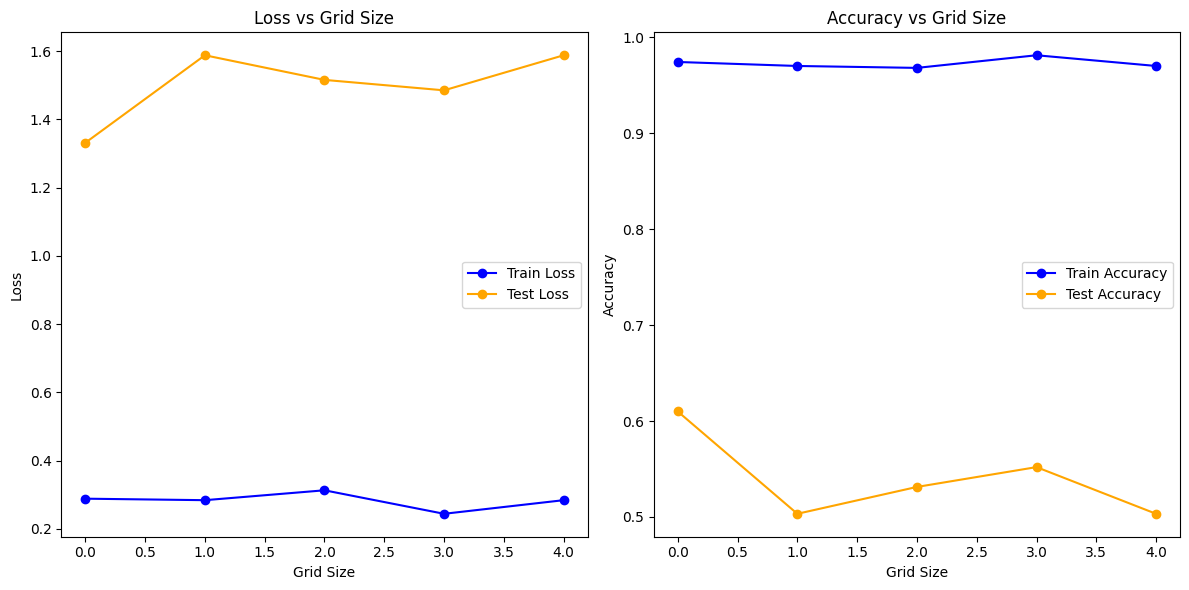

In [3]:
import torch
from models.fcn import GAP1d
from kan import KAN  # Assuming the KAN implementation is available
import matplotlib.pyplot as plt
import json  # For saving metrics
from models.fcn import FCNClassifier
from utils import TimeSeriesClassifier, TimeSeriesDataset
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import nn

steps = 50
NUM_EXPERIMENTS = 5

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LOADING THE MODEL
# optimizer = torch.optim.Adadelta(fcn_model.parameters(), lr=1e-3, eps=1e-8)

# # Load the model (commented out for demonstration, assume `fcn_model` is defined)
# best_model_path = 'experiments/cls_fcn.ckpt'
# fcn_model = FCNClassifier(
#     dimension_num=1,
#     activation=nn.ReLU(),
#     num_classes=3
# )
# optimizer = torch.optim.Adadelta(fcn_model.parameters(), lr=1e-3, eps=1e-8)
# fcn_model = TimeSeriesClassifier.load_from_checkpoint(best_model_path, model=fcn_model, optimizer=optimizer)
fcn_model.to(device)

# Function to extract embeddings and labels from a model
def get_embeddings(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    embeddings_list = []
    labels_list = []

    with torch.no_grad():  # No need to compute gradients
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)  # Move data and labels to the appropriate device
            
            x = data  # Pass the input data through layers
            for layer in model.layers:
                x = layer(x)
                if isinstance(layer, GAP1d):  # Check if the layer is a GAP1d layer
                    embeddings = x  # Capture the output from GAP1d layer
                    break  # Exit the loop after capturing the embeddings

            embeddings_list.append(embeddings.cpu())  # Move embeddings to CPU for storage
            labels_list.append(labels.cpu())  # Move labels to CPU for storage

    # Concatenate embeddings and labels across all batches
    embeddings = torch.cat(embeddings_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    return embeddings, labels

# Get embeddings and labels for train and test data
train_embeddings, train_labels = get_embeddings(fcn_model, train_loader, device)
test_embeddings, test_labels = get_embeddings(fcn_model, test_loader, device)

# Move embeddings and labels to the appropriate device
train_input = train_embeddings.to(device)
test_input = test_embeddings.to(device)
train_label = train_labels.to(device)
test_label = test_labels.to(device)

# Define KAN model input dimensions
n_instances, embedding_size = train_input.shape
n_classes = len(torch.unique(train_labels))  # Number of unique classes in training labels

# Prepare dataset for KAN
dataset = {
    "train_input": train_input,
    "train_label": train_label,
    "test_input": test_input,
    "test_label": test_label,
}


# Iteratively refine grids
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
experiment_num = []

def train_acc():
    preds = torch.argmax(kan_model(dataset["train_input"]), dim=1)
    return torch.mean((preds == dataset["train_label"]).float())

def test_acc():
    preds = torch.argmax(kan_model(dataset["test_input"]), dim=1)
    return torch.mean((preds == dataset["test_label"]).float())

kan_model = None
for experiment in range(NUM_EXPERIMENTS):
    kan_model = KAN(
        ckpt_path='./kan_fcn',
        width=[[embedding_size, 0], [50, 0], [30, 0], [n_classes, 0]],
        k=3,
        seed=42,
        device=device,
    )

    # Train the model and capture the results
    results = kan_model.fit(
        dataset=dataset,
        steps=steps,
        metrics=(train_acc, test_acc),
        loss_fn=torch.nn.CrossEntropyLoss(),
        log=1,
    )
    experiment_num.append(experiment)
    train_losses.append(results["train_loss"][-1])
    test_losses.append(results["test_loss"][-1])
    train_accuracies.append(results["train_acc"][-1])
    test_accuracies.append(results["test_acc"][-1])

# Save the metrics to JSON
metrics = {
    'experiment': experiment_num,
    "train_loss": [loss.item() for loss in train_losses],
    "test_loss": [loss.item() for loss in test_losses],
    "train_acc": train_accuracies,
    "test_acc": test_accuracies,
}
with open("kan_fcn_metrics.json", "w") as f:
    json.dump(metrics, f)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(experiment_num, train_losses, marker="o", label="Train Loss", color="blue")
plt.plot(experiment_num, test_losses, marker="o", label="Test Loss", color="orange")
plt.xlabel("Grid Size")
plt.ylabel("Loss")
plt.title("Loss vs Grid Size")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(experiment_num, train_accuracies, marker="o", label="Train Accuracy", color="blue")
plt.plot(experiment_num, test_accuracies, marker="o", label="Test Accuracy", color="orange")
plt.xlabel("Grid Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Grid Size")
plt.legend()

plt.tight_layout()
plt.show()

# Alguns testes estatísticos

In [6]:
import plotly.express as px
import pandas as pd

df = pd.read_csv('results/final_results.csv')

# Create a boxplot using Plotly
fig = px.box(df, color='classifier_name',x='classifier_name', y='accuracy', title="Accuracy Distribution by Classifier", 
             labels={'classifier_name': 'Classifier', 'accuracy': 'Accuracy'})
fig.update_layout(
    width=700,  # Adjust the width to make it smaller
    height=700,  # Adjust the height if necessary
)

# Show the plot
fig.show()

# TSFRESH + KAN
Ideia abandonada pois não conseguimos fazer o feature extractor do TSFresh funcionar

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from aeon.datasets import load_from_ts_file
from sklearn.preprocessing import LabelEncoder
from kan import KAN
from tsfresh import extract_features
from utils import prepare_tsfresh_data, clean_data

# Load training and testing datasets
if not os.path.exists("./data/ts_files/train.ts") or not os.path.exists("./data/ts_files/test.ts"):
    raise FileNotFoundError("Train or test .ts files not found in the specified directory.")

X_train, y_train = load_from_ts_file("./data/ts_files/train.ts")
X_test, y_test = load_from_ts_file("./data/ts_files/test.ts")

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Prepare the data for TSFresh
train_df = prepare_tsfresh_data(X_train)
test_df = prepare_tsfresh_data(X_test)

# Extract features using TSFresh
X_train_features = extract_features(train_df, column_id="id", column_sort="time")
X_test_features = extract_features(test_df, column_id="id", column_sort="time")

# Clean the extracted features (handle NaNs and remove zero vectors)
X_train_features_clean, y_train_encoded_clean = clean_data(X_train_features, y_train_encoded)
X_test_features_clean, y_test_encoded_clean = clean_data(X_test_features, y_test_encoded)


print(X_train_features_clean.isnull().sum())  # Check NaNs in the training data
print(X_test_features_clean.isnull().sum())   # Check NaNs in the test data
print(y_train_encoded_clean.isnull().sum())
print(y_test_encoded_clean.isnull().sum())

# Convert cleaned features to numpy arrays
X_train_cleaned = X_train_features_clean.values
X_test_cleaned = X_test_features_clean.values

# Define KAN model input dimensions
n_instances, embedding_size = X_train_cleaned.shape
n_classes = len(np.unique(y_train_encoded_clean))  # Number of unique classes in training labels

# Initialize the KAN model
kan_model = KAN(
    width=[[embedding_size, 0], [50, 0], [30, 0], [n_classes, 0]],
    grid=5,
    k=3,
    seed=42,
)

# Prepare dataset for KAN
dataset = {
    "train_input": X_train_cleaned,
    "train_label": y_train_encoded_clean,
    "test_input": X_test_cleaned,
    "test_label": y_test_encoded_clean,
}

# Iteratively refine grids
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
experiment_num = []
steps = 50

def train_acc():
    preds = np.argmax(kan_model.predict(dataset["train_input"]), axis=1)
    return np.mean(preds == dataset["train_label"])

def test_acc():
    preds = np.argmax(kan_model.predict(dataset["test_input"]), axis=1)
    return np.mean(preds == dataset["test_label"])

NUM_EXPERIMENTS = 5
for experiment in range(NUM_EXPERIMENTS):
    kan_model = KAN(
        width=[[embedding_size, 0], [50, 0], [30, 0], [n_classes, 0]],
        grid=5,
        k=3,
        seed=42,
    )

    # Train the model and capture the results
    results = kan_model.fit(
        ckpt_path='./kan_feature_ext',
        dataset=dataset,
        steps=steps,
        metrics=(train_acc, test_acc),
        loss_fn="cross_entropy",  # Replace with appropriate loss function for KAN
        log=1,
    )
    experiment_num.append(experiment)
    train_losses.append(results["train_loss"][-1])
    test_losses.append(results["test_loss"][-1])
    train_accuracies.append(results["train_acc"][-1])
    test_accuracies.append(results["test_acc"][-1])

# Save the metrics to JSON
metrics = {
    'experiment': experiment_num,
    "train_loss": train_losses,
    "test_loss": test_losses,
    "train_acc": train_accuracies,
    "test_acc": test_accuracies,
}
with open("kan_metrics.json", "w") as f:
    json.dump(metrics, f)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(experiment_num, train_losses, marker="o", label="Train Loss", color="blue")
plt.plot(experiment_num, test_losses, marker="o", label="Test Loss", color="orange")
plt.xlabel("Grid Size")
plt.ylabel("Loss")
plt.title("Loss vs Grid Size")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(experiment_num, train_accuracies, marker="o", label="Train Accuracy", color="blue")
plt.plot(experiment_num, test_accuracies, marker="o", label="Test Accuracy", color="orange")
plt.xlabel("Grid Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Grid Size")
plt.legend()

plt.tight_layout()
plt.show()

Feature Extraction: 100%|██████████| 30/30 [00:08<00:00,  3.65it/s]
c:\Users\andre\anaconda3\envs\pykan\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__mean_abs_change' 'value__mean_change'
 'value__mean_second_derivative_central' 'value__skewness'
 'value__kurtosis' 'value__sample_entropy' 'value__autocorrelation__lag_0'
 'value__autocorrelation__lag_1' 'value__autocorrelation__lag_2'
 'value__autocorrelation__lag_3' 'value__autocorrelation__lag_4'
 'value__autocorrelation__lag_5' 'value__autocorrelation__lag_6'
 'value__autocorrelation__lag_7' 'value__autocorrelation__lag_8'
 'value__autocorrelation__lag_9' 'value__partial_autocorrelation__lag_0'
 'value__partial_autocorrelation__lag_1'
 'value__partial_autocorrelation__lag_2'
 'value__partial_autocorrelation__lag_3'
 'value__partial_autocorrelation__lag_4'
 'value__partial_autocorrelation__lag_5'
 'value__partial_autocorrelation__lag_6'
 'value__partial_autocorrelation__lag_7'
 'v

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:07<?, ?it/s]

lstsq failed


UnboundLocalError: local variable 'coef' referenced before assignment